# Deep Belief Modeling
Project for SI course

## Imports

In [27]:
import imageio as imageio
import pandas as pd

## Loading data

In [28]:
df_train = pd.read_csv("resources/data.csv", sep="\t")
# maybe add test data in future

## Input data visualisation

<AxesSubplot:>

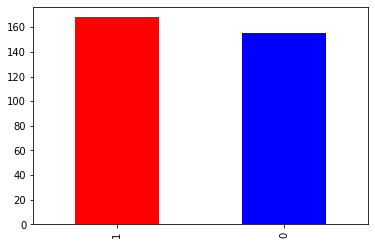

In [29]:
x = df_train["label"].value_counts()
x.plot(kind="bar", color=["r", "b"])

## Text pre-processing for classification

In [30]:
from preprocessing.article import word_preprocess

In [31]:
print(df_train["data"].head(10))
print(df_train["data"].head(10).apply(word_preprocess))

0    It's been quite a week. I've been in the media...
1    This week has been eye-opening. Even for me --...
2    Yes, it's true. I beat COVID-19 in 48 hours wi...
3    The COVID-19 vaccines appear to be causing a g...
4    Back in the 1980s, I was a Columbia University...
5    So you got the vaccine because they told you t...
6    I Am A Living Proof That COVID-19 Is Fake This...
7    I have a PhD in virology and immunology. I’m a...
8    How do you convince the world’s population to ...
9    Take 15 minutes and listen to this interview w...
Name: data, dtype: object
0    [quite, week, medium, business, decade, never,...
1    [week, eye, opening, even, guy, warned, year, ...
2    [yes, true, beat, covid, hour, ivermectin, get...
3    [covid, vaccine, appear, causing, global, heal...
4    [back, columbia, university, student, learning...
5    [got, vaccine, told, get, forced, get, joe, bi...
6    [living, proof, covid, fake, unfiltered, take,...
7    [phd, virology, immunology, clinic

## Feature selection

### TF-IDF Vectorizer

In [32]:
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
import pickle

with open("model_storage/vectorizer.pkl","rb") as file:
    tfidf_vectorizer = pickle.load(file)

with open("model_storage/bow.pkl","rb") as file:
    tfidf_wm = pickle.load(file)

with open("model_storage/classifier.pkl","rb") as file:
    clf = pickle.load(file)

tfidf_tokens = tfidf_vectorizer.get_feature_names_out()

print(tfidf_tokens)

df_tfidf_vect = pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf_tokens)

print("Tf-idf vectorizer")
print(df_tfidf_vect)

['aabduzrw' 'aaby' 'aadhaar' ... 'zoster' 'zuckerberg' 'zurich']
Tf-idf vectorizer
     aabduzrw  aaby  aadhaar  aaho  aamc  aamcnews  aap  aaphowever  aarogya  \
0         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
1         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
2         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
3         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
4         0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
..        ...   ...      ...   ...   ...       ...  ...         ...      ...   
318       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
319       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
320       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
321       0.0   0.0      0.0   0.0   0.0       0.0  0.0         0.0      0.0   
322       0.0   0.0      0.0   0.0   

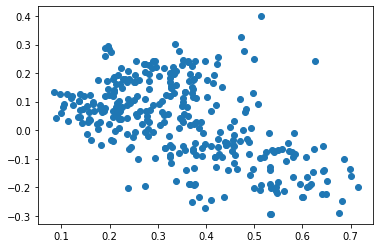

In [33]:
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

clftr = TruncatedSVD(2)
Xpca = clftr.fit_transform(tfidf_wm)
plt.scatter([x[0] for x in Xpca],[x[1] for x in Xpca])
plt.show()

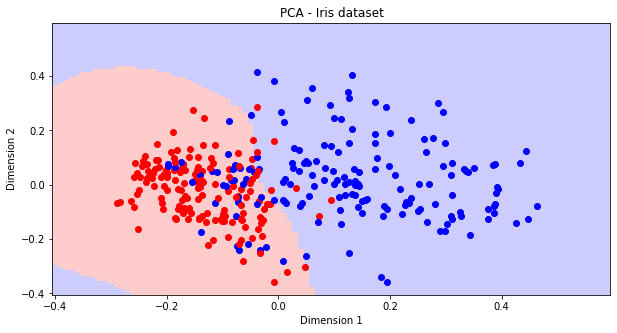

In [34]:
from random import randint
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
h = .01
x_min, x_max = -0.4,0.6
y_min, y_max = -0.4,0.6
# loading dataset
data = load_iris()
X, y = tfidf_wm.toarray(), df_train["label"]
# selecting first 2 components of PCA
X_selected = PCA(2).fit_transform(X)
# training classifier and evaluating on the whole plane
clfsvc = SVC()
clfsvc.fit(X_selected,y)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clfsvc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plotting
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.figure(figsize=(10,5))
plt.pcolormesh(xx, yy, Z, alpha=.6,cmap=cmap_light)
plt.title('PCA - Iris dataset')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for xy,c in zip(X_selected,df_train["label"]):
    plt.scatter(xy[0],xy[1],c= 'red' if c == 0 else 'blue')
plt.show()


In [35]:
from model.features import f_importances_graph

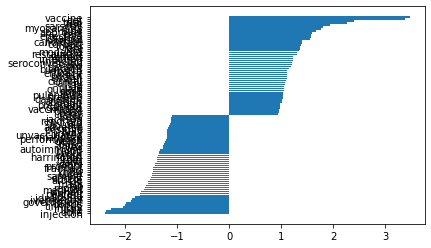

In [36]:
slowa_anty, slowa_pro = f_importances_graph(clf.coef_,tfidf_tokens, limit=50)

In [37]:
with open("model_storage/words_pa.pkl","rb") as file:
    words_pa = pickle.load(file)

In [38]:
# wektory artykułów
from collections import Counter,defaultdict
from sklearn.feature_extraction.text import TfidfTransformer

slowa_kluczowe = [s for _,s in slowa_pro+slowa_anty]
article_vectors = []


for a in words_pa:
    zliczone = Counter([word for word in a if word in slowa_kluczowe])
    article_vectors.append([zliczone[s] for s in slowa_kluczowe])

article_vectors = TfidfTransformer().fit_transform(article_vectors)

In [39]:
# wektory słów od słów dla każdego artykułu

#print(prepare_dictionary(words_pa,slowa_anty+slowa_pro).keys())

r = 2
words = [w for _,w in slowa_anty+slowa_pro]
slowa = words
bliskie_slowa = set()
for a in words_pa:
    for i, w in enumerate(a):
        if w in slowa:
            for n in range(max(i - r, 0), min(i + r, len(a))):
                if a[n] not in slowa:
                    bliskie_slowa.add(a[n])

bliskie_slowa = list(bliskie_slowa)
matrix_pro = []
matrix_anty = []
for article_index,article in enumerate(words_pa):
    if df_train["label"][article_index] == 0:
        slowa = [sl for _,sl in slowa_anty]
        matrix = matrix_anty
    else:
        slowa = [sl for _,sl in slowa_pro]
        matrix = matrix_pro
    kluczowe_w_artykule = [s for s in slowa if s in article]
    matrix.append([np.zeros(len(bliskie_slowa)) for s in kluczowe_w_artykule])
    for word_index,s in enumerate(article):
        if s in slowa:
            for n in range(max(word_index - r, 0), min(word_index + r, len(article))):
                if article[n] not in words:
                    matrix[-1][kluczowe_w_artykule.index(s)][bliskie_slowa.index(article[n])] += 1

In [40]:
for i in range(len(matrix_pro)):
    matrix_pro[i] = TfidfTransformer().fit_transform(matrix_pro[i]).toarray()

for i in range(len(matrix_anty)):
    matrix_anty[i] = TfidfTransformer().fit_transform(matrix_anty[i]).toarray()

In [41]:
slowa = {sl: {s: 0 for s in bliskie_slowa} for _,sl in slowa_pro+slowa_anty}
for article_index,article in enumerate(words_pa):
    for word_index,s in enumerate(article):
        if s in slowa:
            for n in range(max(word_index - r, 0), min(word_index + r, len(article))):
                if article[n] not in words:
                    slowa[s][article[n]] += 1

vectors = TfidfTransformer().fit_transform([list(w.values()) for w in slowa.values()])

lista przeczytanych artykułów
na bierząco generowane wektory ze wszystkich
przeczytanych artykułów
wektory mają długość całego sąsiedztwa słów

learnig_rate


 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 14.874181337363027


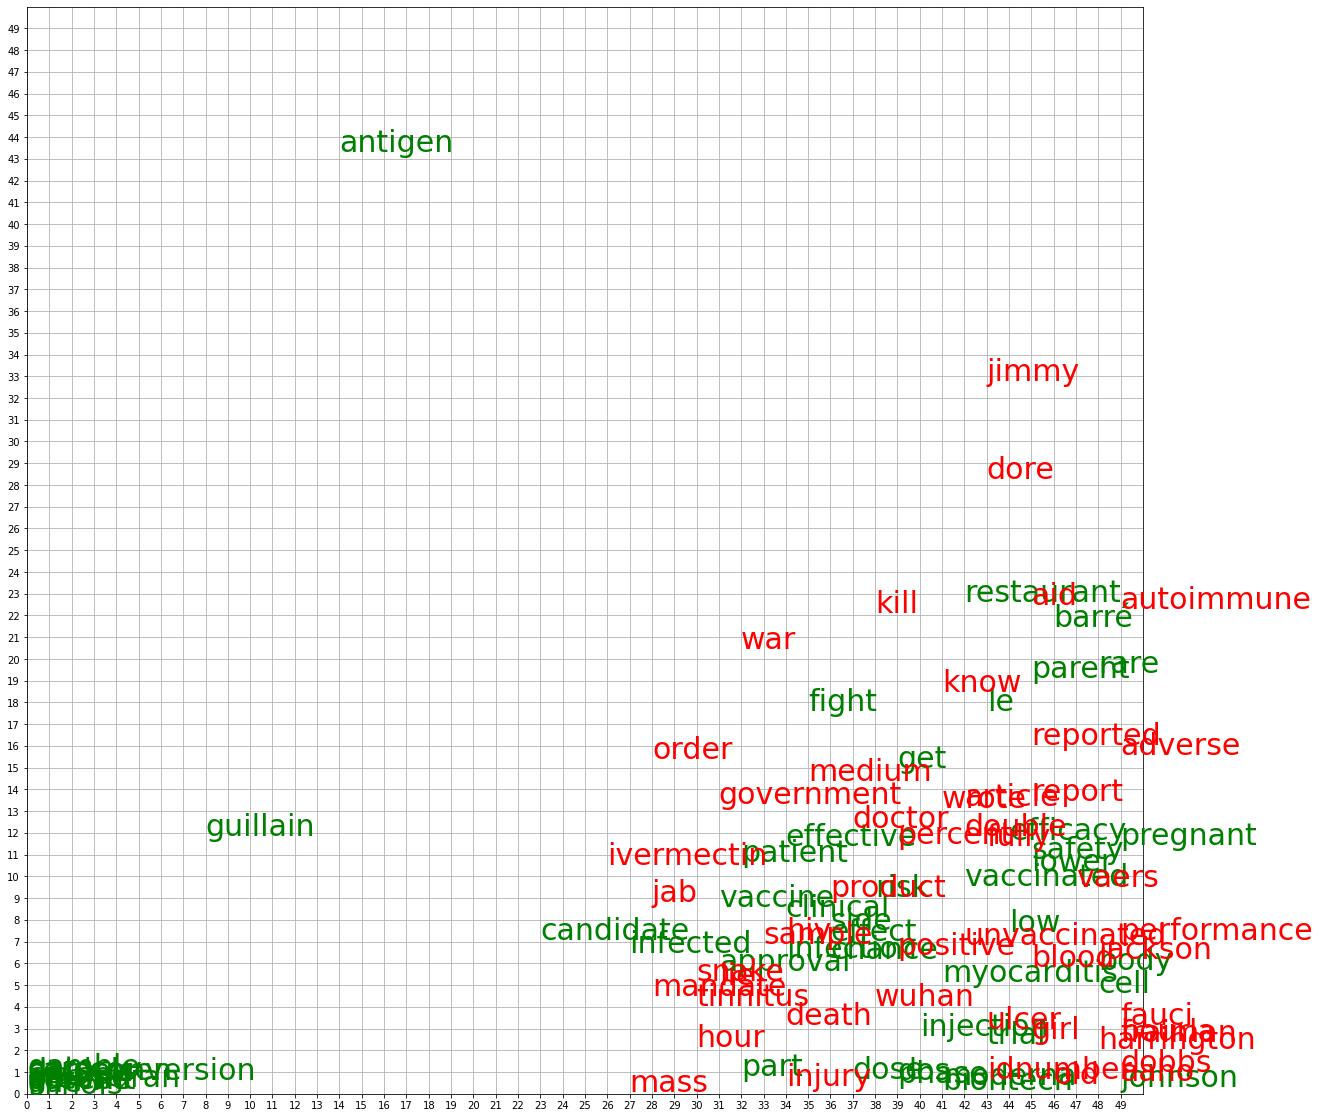

 [ 426 / 500 ]  85% - 0:00:26 left 

In [ ]:
from minisom import MiniSom
from random import sample
from preprocessing.vectors import prepare_dictionary,generate_vectors, find_close_words

def random_percent(data,percent):
    if percent<=1:
        return sample(data,k=int(len(data)*percent))
    return None

key_words = [s for _,s in slowa_pro + slowa_anty]
close_words = find_close_words(words_pa,key_words)
pro_words_pa = [words for i,words in enumerate(words_pa) if df_train["label"][i]==1]
anti_words_pa = [words for i,words in enumerate(words_pa) if df_train["label"][i]==0]

def plot_vectors(som,vectors,N):
    x = plt.figure(figsize=(20, 20))

    for _, (t, c, vec) in enumerate(zip(key_words, ['r' if i>len(slowa_pro) else 'g' for i,_ in enumerate(slowa_kluczowe)], list(vectors.values()))):
        winnin_position = som.winner(vec)
        plt.text(winnin_position[0], winnin_position[1]+np.random.rand()*.9,t,fontsize=30,color=c)

    plt.xticks(range(N))
    plt.yticks(range(N))
    plt.grid()
    plt.xlim([0, N])
    plt.ylim([0, N])
    plt.plot()
    plt.show()
    plt.close(x)

def sim(wiedza,do_czytania,learning_rate):
    # wiedza na start
    read_data = random_percent(wiedza,0.8)
    vectors = generate_vectors(prepare_dictionary(read_data,key_words,r=2),close_words)

    N = int(5*np.sqrt(len(vectors)))
    som = MiniSom(N, N, len(close_words), sigma=3, learning_rate=learning_rate, activation_distance='cosine')
    som.train_random(list(vectors.values()),500,verbose=True)

    plot_vectors(som,vectors,N)

    read_data.extend(random_percent(do_czytania,0.5))
    vectors = generate_vectors(prepare_dictionary(read_data,key_words,r=2),close_words)

    som.train_random(list(vectors.values()),500,verbose=True)

    plot_vectors(som,vectors,N)

sim(anti_words_pa,pro_words_pa,0.5)